# Identifying Similar Graphic Design Templates

# The Aim

Several companies are springing up that offer ready-made graphic design templates,
in categories such as business cards, invitations and presentations. These kind of templates
all similar in a sense, but there is lots of variation between them that makes some
likable to one user, and unlikable to another. For example all birthday invitations
have similar words on them _"You're invited to my birthday ... it's on YYYY-MM-DD"_
but there's many different layouts, colours and graphics that make it personalised.

With the more templates being created, it is easy to get overwhelmed, close the browser and
give up on trying to find one you like. Can this experience be improved? Is it possible
to offer up suggestions of what a user may like based on what they click on?
Rather than a user clicking through Page 1 up to Page 100, could they go down a rabbit-hole
of suggested templates, slowly refining it down until they find the one they want?

The aim of this little project is to see if we can offer up similar graphic design templates
based on an input template. There has been work done in the past on finding similar songs
based on an input song ([link](https://github.com/spotify/annoy)) and on finding similar
photographs ([link](https://www.kaggle.com/abhikjha/fastai-hooks-and-image-similarity-search)).
Can we extend that same approach to design templates?

(Click [here](#results) if you want to skip to the end and see the results.)

# The Method

The basic principle that both methods listed above use is to generate a list of numeric values that can describe
each object. Finding "similar" templates is then about selecting out the templates that have the lowest overall difference
between its numeric features and the original object's. Another way to think of this is plotting the object into multi-dimensional space, and selecting out the other objects that are "closest" to it.

For our project we narrowed down on a specific type of graphic design templates: **invitations**.

There are different ways to construct a "Numeric Feature Generator" <sup>TM</sup> for invitations.

The first is to think about different metrics that would define a graphic design. For example, they could be broken into three categories: the text used, the graphics added and the overall layout. The text might be large/small, sans-serif/script. The graphics might be vector-based/hand-drawn, floral/industrial. The layout might be minimal/crowded. With a set of metrics you could label each of your graphics with that information. It would be hard if you don't have the individual elements available. If you could pull it off, the benefit is that these numbers are very explainable to a person off the street.

I didn't have access to this kind of info so had to make do with something else. I tried to let a machine learn the key features of a design and see if it was _good enough_ for finding similar graphics. This approach involves setting a machine to learn the images with the task of trying to classify invitations based on their type: weddings, birthdays, bbqs and graduations. As part of that process, the very last stage before the machine will output it's prediction, it generates a 500-length list of numeric features that it weighs up to make it's final decision. Ignoring it's final prediction, pulling this 500-length vector for each of the invitations would do well as a list of numeric features.

# The Data

I needed to get a set of images of invitations. A well-worded google search and a web scrape meant I was able to
get around 150 images per category (bbq, wedding, birthday, graduation). There's lots of noise in google search so doing something like `"birthday invitations site:canva.com"` did the job. The benefit of this is that we get the image labelling for free; all images downloaded in each search can be matched to their category.

The files are hosted at www.kaggle.com/dataset/ba3a5d2a48e4ff588a95247c934eec123cc0b5c27d46cc53f5ac471b91a39855.

# The Model

I need to credit the sources I used to generate this methodology. Firstly,
the first fast.ai course [here](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb). Secondly, [this kaggle kernel](https://www.kaggle.com/abhikjha/fastai-hooks-and-image-similarity-search) by Abhik Jha.

The approach is to train a resnet50 model (a 50 layer residual network). We train the model for several epochs (one epoch is one pass over the dataset).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from annoy import AnnoyIndex
from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import display, Markdown, HTML

In [2]:
%matplotlib inline

np.random.seed(1234)

def md(text):
    display(Markdown(text))

In [3]:
path_img = "/kaggle/input/invitations_all"

fnames = get_image_files(path_img)

pat = r'invitations_all/([\w]+)_.*$'

In [4]:
md(f"We have a total of {len(fnames)} template images.")

We have a total of 398 template images.

In [5]:
data = ImageDataBunch.from_name_re(
    path_img,
    fnames,
    pat,
    ds_tfms=get_transforms(),
    size=299,
    bs=64 // 2
).normalize(imagenet_stats)

We can see some example images below.

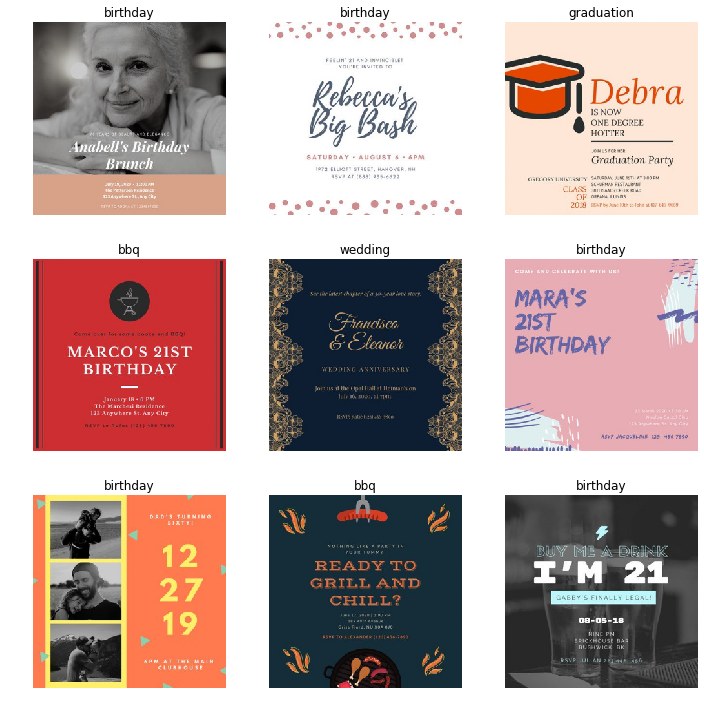

In [6]:
ImageDataBunch.from_name_re(
    path_img,
    fnames,
    pat,
    size=299,
).show_batch(rows=3, figsize=(10,10))

This first step involves finding an optimal learning rate for our later fine tuning.

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


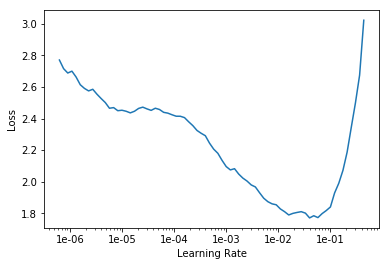

In [7]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.model_dir = "/kaggle/working/model"

learn.lr_find()
learn.recorder.plot()

In [8]:
learn.fit_one_cycle(8)

learn.save('stage-1')

Using the plot above we fine-tune the model with a variable learning rate for a few epochs.

In [9]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

With the model trained. We can investigate how well it is performing. It is important to note that
a high accuracy classification model isn't _necessary_ for us to generate our recommender system.
We only care about the second-last step that contains the feature vector. However, the higher
the accuracy the more confidence we can have that
the model is focusing on the right features.

Plotted below is the worst predictions. The heatmap shows us what the model
is focussing on in making its prediction. We can see that the model can sometimes
make its decisions based on a very small element of the graphic, like stars suggesting birthdays,
apples meaning bbqs or a floral wreath suggesting a wedding invitation.

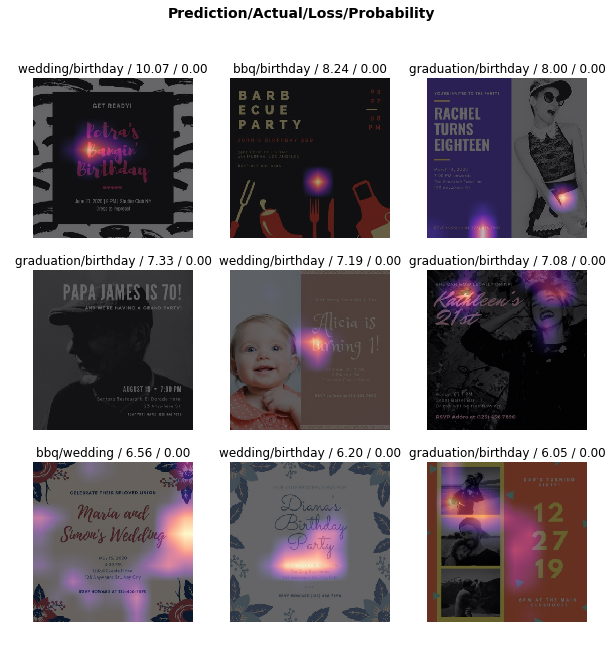

In [10]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_top_losses(9, figsize=(10, 10), heatmap=True)

We can plot the confusion matrix of the model. To compare what it is predicting versus
the true labels. It seems that there's a lot of overlap with birthdays and weddings.
This checks out as there's lots of shared design elements between the wedding
and birthday graphics that are present in the data (floral wreaths are a popular
design element for both).

The model is performing as can be expected with so few samples and lots of overlap
in the classes. Let's continue.

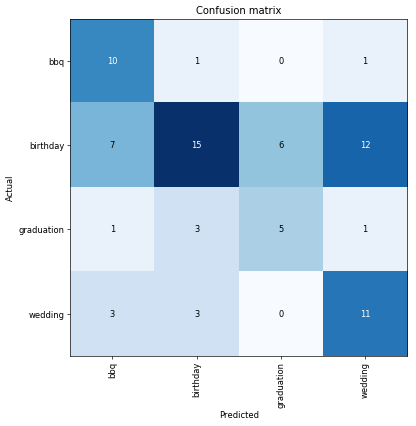

In [11]:
interp.plot_confusion_matrix(figsize=(7, 7), dpi=60)

This next step (credit to the kaggle notebook I linked above) is the extracting of the feature
vectors.

In [12]:
class SaveFeatures():
    """
    Source: https://www.kaggle.com/abhikjha/fastai-hooks-and-image-similarity-search
    """
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [13]:
sf = SaveFeatures(learn.model[-1][4])

_ = learn.get_preds(data.train_ds)
_ = learn.get_preds(DatasetType.Valid)

In [ ]:
repr_length = sf.features.shape[1]

This has produced a vector of length 512 for _every_ image.
This can be thought of as a point in space (except with many more dimensions!)
This vector means we can figure out how __semantically__ different
two images are by calculating the __distance__ between their two vector representations.

We can see below a table of the images with their vector representations.

In [15]:
all_images = list(data.train_ds.items) + list(data.valid_ds.items)

image_repr = pd.DataFrame({
    "image": [str(image) for image in all_images],
    "repr": sf.features.tolist()
})

image_repr.head()

image  \
0  /kaggle/input/invitations_all/wedding_canva-bl...   
1  /kaggle/input/invitations_all/graduation_canva...   
2  /kaggle/input/invitations_all/birthday_canva-p...   
3  /kaggle/input/invitations_all/wedding_canva-cr...   
4  /kaggle/input/invitations_all/wedding_canva-te...   

                                                repr  
0  [6.087993621826172, 7.514327049255371, 1.19154...  
1  [0.18885678052902222, 4.393500804901123, -3.27...  
2  [-1.17294442653656, 2.6533336639404297, 4.4571...  
3  [4.90797233581543, -1.0578984022140503, -0.624...  
4  [6.277919769287109, 0.7731039524078369, -3.842...

Comparing these vectors is a slow process, we can use the Approximate Nearest Neighbours to speed it up.

In [16]:
annoy_index = AnnoyIndex(repr_length, metric='euclidean')

for i, vector in enumerate(image_repr["repr"]):
    annoy_index.add_item(i, vector)
    
_ = annoy_index.build(50)

In [17]:
def get_similar_images_df(img_index: str, annoy: AnnoyIndex, 
                          repr_df: pd.DataFrame, n: int = 9):
    img_id = repr_df.iloc[img_index, 0]
    
    # the first result will be itself, so we search for n + 1` and remove `img_index` from the results
    similar_img_ids = annoy.get_nns_by_item(img_index, n + 1)
    similar_img_ids.remove(img_index)
    
    return img_id, repr_df.iloc[similar_img_ids]

def show_comparison(img_indices: List[int], annoy: AnnoyIndex, repr_df: pd.DataFrame, n: int = 5):
    axes = subplots(rows=len(img_indices), cols=n, imgsize=4)
    for img_index, axes_row in zip(img_indices, axes):
        base_image, similar_images_df = get_similar_images_df(img_index, annoy, repr_df)
        open_image(base_image).show(ax=axes_row[0])        
        comparison_images = [open_image(image) for image in similar_images_df["image"]]
        for img, axes_col in zip(comparison_images, axes_row[1:]):
            img.show(ax=axes_col)
        plt.tight_layout()

# The Results <a name="results"></a>

Let's take a look at how the model performed. Each row is one lot of suggestions. The first column in each row contains the input image and the rest are the top suggestions based on how similar they are. We can see that, for this small sample the results seem positive!

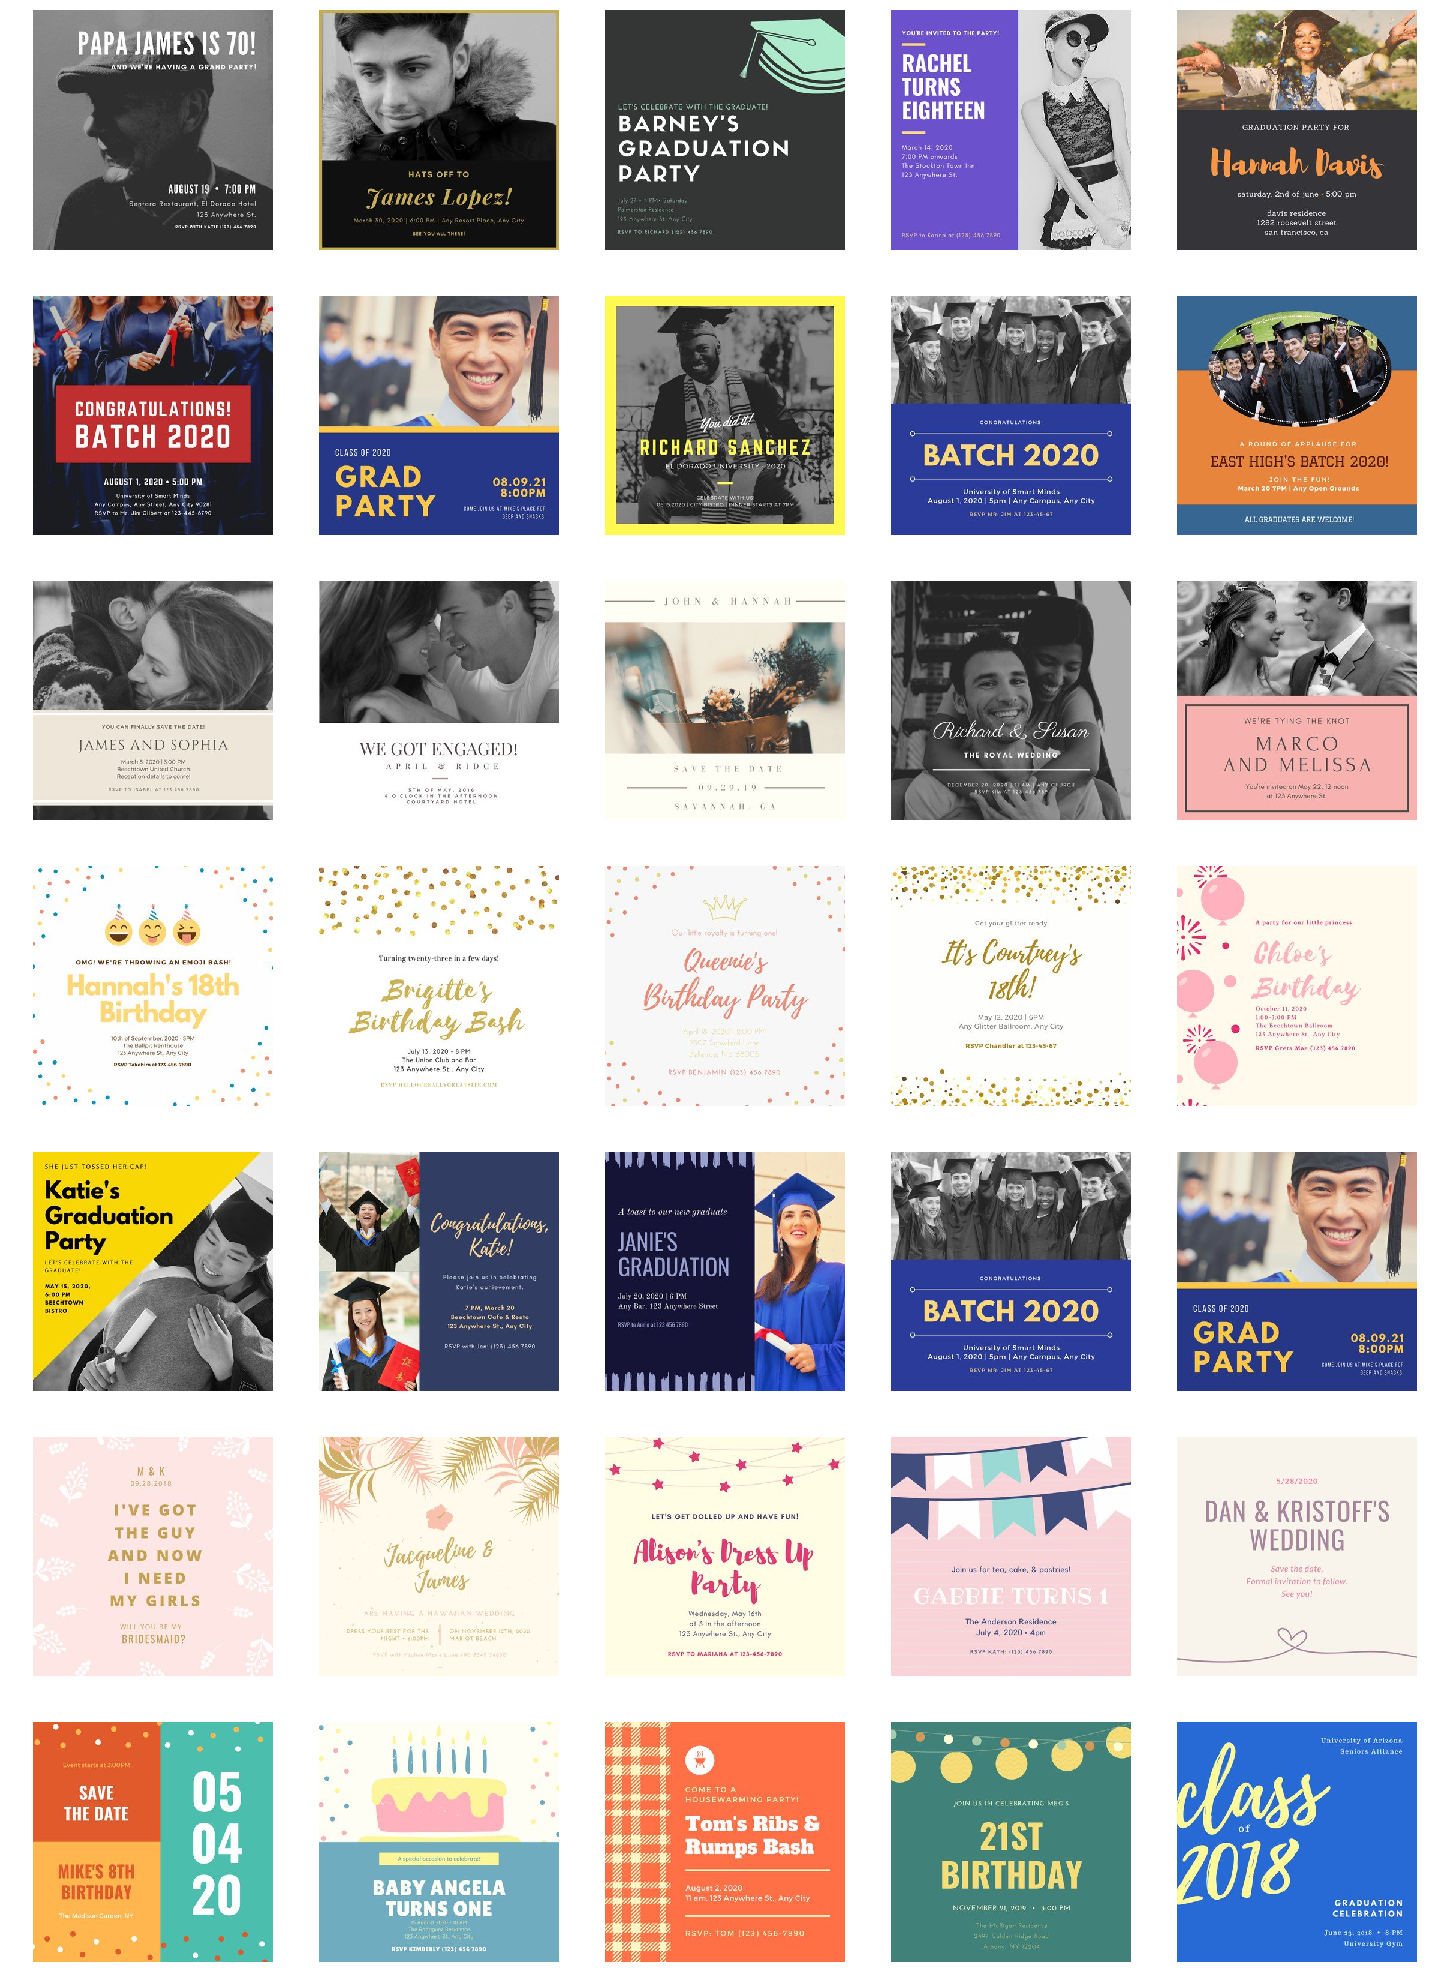

In [18]:
show_comparison(np.random.randint(0, len(image_repr), 7), annoy_index, image_repr, n=5)

# Where to from here

We can see that the similar images offered do well at picking out macro layout effects (flower border, large numbers, photo frame). However, it could improve on it's comparison of micro _style_ elements (fonts, colours, humourous/serious).

Going forward we should attempt with more data. In a production setting you would imagine a company would run it on _all_ of their designs. There's only so much I can recommend if I only have 400 to choose from.